# Interpret regression models using Boston House Prices Dataset

This notebook demonstrates how to apply `Captum` library on a regression model and understand important features, layers / neurons that contribute to the prediction. It compares a number of attribution algorithms from `Captum` library for a simple DNN model trained on a sub-sample of a well-known Boston house prices dataset.

Note that in order to be able to run this notebook successfully you need to install scikit-learn package in advance.


In [1]:
import numpy as np

from os import path


import matplotlib.pyplot as plt

#scikit-learn related imports
import sklearn
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation


In [3]:
torch.manual_seed(1234)
np.random.seed(1234)

Para que el codigo funcione es necesario cambiar en /home/diego/weather-control/code/models/seq2seq/seq2seq_2layers_2heads.py
```
def forward(self, input_seq: torch.tensor) -> tuple:
        """..."""
        if self.device == 'cuda' and not torch.cuda.is_available():  # esto hace que modelos entrenados en GPU corran en CPUS
            self.device = 'cpu'  
```
Por 
```
def forward(self, input_seq: torch.tensor) -> tuple:
        """..."""
        if self.device == 'cuda':
            self.device = 'cpu' 
```

In [6]:
import click
import yaml
import pickle
import torch
import copy
import numpy as np
from datetime import datetime
from attrdict import AttrDict
from tqdm import tqdm
from colorama import Fore, Style
from pathlib import Path
from torch.utils.data import DataLoader

import common.predict.modules as predictor
from common.utils.parser import parser
import common.utils.kwargs_gen as generar_kwargs
from common.utils.datasets import dataset_pmodel as ds_pmodel
from common.utils.datasets import sampler_pmodel as sa_pmodel
from common.utils.datasets import dataset_pipeline as ds_pipeline
from common.utils.datasets import sampler_pipeline as sa_pipeline

from common.utils.datasets import dataset_seq2seq as ds
from common.utils.datasets import sampler_seq2seq as sa
from common.utils.trainers import trainerSeq2Seq as tr
from common.utils.trainers import trainerpmodel as tr_pmodel

FILE = '../experiments/experimentoFINAL/FINAL.yml'
OK = 'OK'

try:
    print(f"\tArchivo de configuracion {FILE}", end="")
    with open(FILE, 'r') as handler:
        cfg = yaml.safe_load(handler)
        name = cfg["experiment"]
        epoch = cfg["zmodel"]["dataloaders"]["test"]["use_checkpoint"]
        cfg = AttrDict(parser(name, epoch)(cfg))
        print(f"\t\t\t\t\t\t{OK}")
    print(f"\tDatos de estaciones de zona {Path(cfg.paths.zmodel.dataset)}", end="")    
    with open(Path(cfg.paths.zmodel.dataset), 'rb') as handler:
        datasets = pickle.load(handler)
        print(f"\t\t\t\t{OK}")
    print(f"\tMetadatos de estaciones de zona {Path(cfg.paths.zmodel.dataset_metadata)}", end="")
    with open(Path(cfg.paths.zmodel.dataset_metadata), 'r') as handler:
        metadata = yaml.safe_load(handler)
        print(f"\t\t\t\t{OK}")
except Exception as e:
    print(f"El archivo de configuracion del experimento no existe o no existe el archivo {cfg.paths.zmodel.dataset} \
        con los datasets para el modelo zonal o {cfg.paths.zmodel.dataset_metadata} de metadatos del dataset del \
        modelo zonal. Mas info: {e}")
        
        
device = 'cpu'
Fout = len(cfg.prediccion)
print(Fore.YELLOW + f"CUDA: {'SI' if device == 'cuda' else 'NO'}" + Style.RESET_ALL)
    
print(f"\tInicio del dataset en {metadata['fecha_min']}")
kwargs_dataloader = generar_kwargs.dataloader(modelo='zmodel', fase='validation', cfg=cfg, datasets=datasets, metadata=metadata)
kwargs_prediccion = generar_kwargs.predict(modelo='zmodel', cfg=cfg)

test_dataloader = predictor.generar_test_dataset(**kwargs_dataloader)

kwargs_prediccion = generar_kwargs.predict(modelo='zmodel', cfg=cfg)

path_checkpoints = kwargs_prediccion.get('path_checkpoints', None)
use_checkpoint = kwargs_prediccion.get('use_checkpoint', None)
path_model = kwargs_prediccion.get('path_model', None)
   
model = torch.load(Path(path_model) , map_location=torch.device('cpu'))
model.to(device)

trainer = tr.TorchTrainer(model=model, 
                                        device=device,
                                        checkpoint_folder= path_checkpoints)
       
if use_checkpoint == 'best':
    trainer._load_best_checkpoint()
model.to(torch.device('cpu'))   
Xf, X, Yt, Y, P = next(iter(test_dataloader))
y_pred = model(Xf, X, Yt, Y, P)[...,0]
y_pred.shape


	Archivo de configuracion ../experiments/experimento/ZP1.ymlEl archivo de configuracion del experimento no existe o no existe el archivo /home/diego/weather-control/experiments/experimentoZP1/data/dataset_zmodel.pickle         con los datasets para el modelo zonal o /home/diego/weather-control/experiments/experimentoZP1/data/dataset_zmodel.yaml de metadatos del dataset del         modelo zonal. Mas info: [Errno 2] No such file or directory: '../experiments/experimento/ZP1.yml'
CUDA: NO
	Inicio del dataset en 2018-01-01 00:00:00
Generando dataset desde 26664.0 a 28463.0: 2021-01-16 00:00:00 a 2021-03-31 23:00:00
loaded checkpoint for epoch - 12


torch.Size([7, 72])

TEMPERATURA

In [30]:
def wrapper(Xf, X, Yt, Y, P):
    y_pred = model(Xf, X, Yt, Y, P)[...,0]
    return torch.mean(y_pred, dim=0)

ig = IntegratedGradients(wrapper)

attrs = []
for i, (Xf, X, Yt, Y, P) in tqdm(enumerate(test_dataloader)):
        attr = ig.attribute(inputs=(Xf), additional_forward_args=(X, Yt, Y, P)).cpu().data.numpy()
        attrs.append(np.mean(attr, axis=0))

    
attrs = np.concatenate(attrs, axis=0)
attrs = np.mean(attrs, axis=0)
g_attr_test_norm_sum = attrs / np.linalg.norm(attrs, ord=1)


1800it [31:32,  1.05s/it]


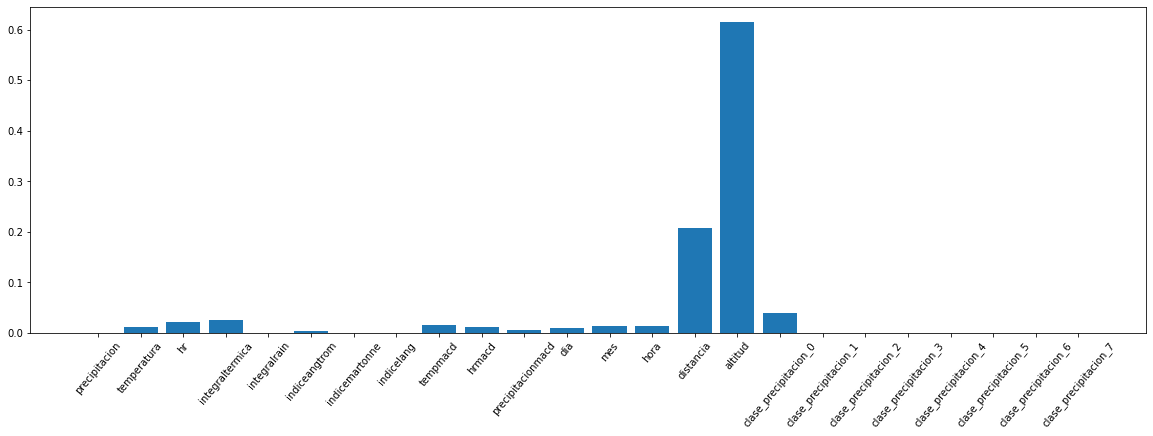

In [32]:
%matplotlib inline
index = [  'precipitacion', 'temperatura', 'hr', 'integraltermica', 'integralrain',
       'indiceangtrom', 'indicemartonne', 'indicelang', 'tempmacd', 'hrmacd', 'precipitacionmacd', 
       'dia', 'mes', 'hora', 'distancia', 'altitud',
       'clase_precipitacion_0', 'clase_precipitacion_1', 'clase_precipitacion_2',
       'clase_precipitacion_3', 'clase_precipitacion_4', 'clase_precipitacion_5',
       'clase_precipitacion_6', 'clase_precipitacion_7']
plt.figure(figsize=(20,6))
plt.bar(index, np.abs(g_attr_test_norm_sum))
plt.tick_params(axis="x", rotation=50)


HUMEDAD RELATIVA

In [33]:
def wrapper(Xf, X, Yt, Y, P):
    y_pred = model(Xf, X, Yt, Y, P)[...,1]
    return torch.mean(y_pred, dim=0)

ig = IntegratedGradients(wrapper)

attrs = []
for i, (Xf, X, Yt, Y, P) in tqdm(enumerate(test_dataloader)):
        attr = ig.attribute(inputs=(Xf), additional_forward_args=(X, Yt, Y, P)).cpu().data.numpy()
        attrs.append(np.mean(attr, axis=0))

    
attrs = np.concatenate(attrs, axis=0)
attrs = np.mean(attrs, axis=0)
g_attr_test_norm_sum = attrs / np.linalg.norm(attrs, ord=1)

1800it [32:15,  1.08s/it]


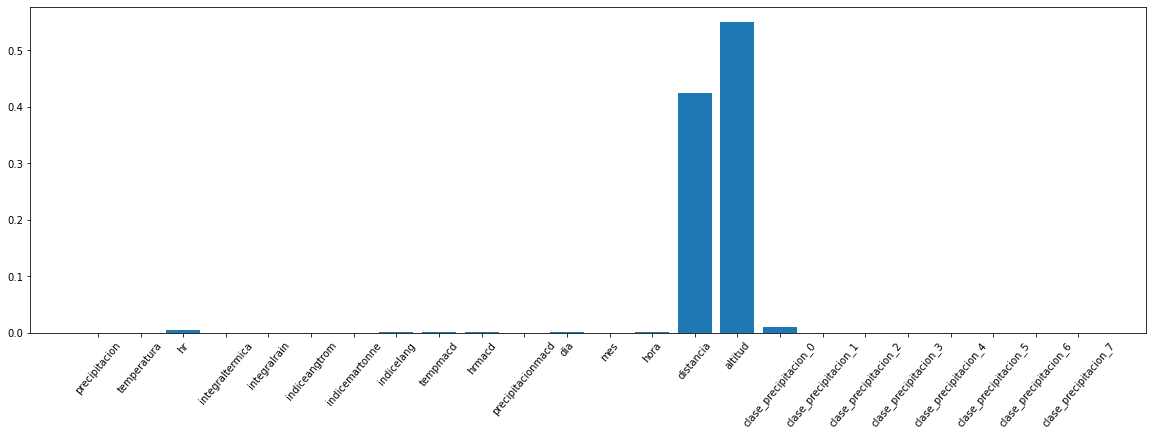

In [34]:
%matplotlib inline
index = [  'precipitacion', 'temperatura', 'hr', 'integraltermica', 'integralrain',
       'indiceangtrom', 'indicemartonne', 'indicelang', 'tempmacd', 'hrmacd', 'precipitacionmacd', 
       'dia', 'mes', 'hora', 'distancia', 'altitud',
       'clase_precipitacion_0', 'clase_precipitacion_1', 'clase_precipitacion_2',
       'clase_precipitacion_3', 'clase_precipitacion_4', 'clase_precipitacion_5',
       'clase_precipitacion_6', 'clase_precipitacion_7']
plt.figure(figsize=(20,6))
plt.bar(index, np.abs(g_attr_test_norm_sum))
plt.tick_params(axis="x", rotation=50)